In [1]:
import pandas as pd
import re
import os

def extract_email_only(sender_text):
    """
    Extract ONLY the email address from any text format.
    This function uses a more aggressive approach to find and isolate just the email.

    Args:
        sender_text (str): The sender field text that might contain names and other content

    Returns:
        str: Only the extracted email address or empty string if none found
    """
    # Convert to string in case it's not
    sender_text = str(sender_text).strip()

    # Comprehensive regex pattern to extract email addresses
    email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'

    match = re.search(email_pattern, sender_text)
    if match:
        # Return only the matched email address
        return match.group(0)
    else:
        # If no email found, return empty string or some placeholder
        return ""

def clean_sender_column(input_file, output_file=None):
    """
    Process a CSV file to extract ONLY email addresses from the sender field,
    completely removing names and other text.

    Args:
        input_file (str): Path to input CSV file
        output_file (str, optional): Path to output CSV file

    Returns:
        str: Path to the output file
    """
    try:
        # Create default output filename if not provided
        if output_file is None:
            base_name = os.path.splitext(input_file)[0]
            output_file = f"{base_name}_cleaned.csv"

        # Read the CSV file
        df = pd.read_csv(input_file)
        print(f"Read {len(df)} rows from {input_file}")

        # Display column names
        print(f"Available columns: {df.columns.tolist()}")

        # Get sender column name
        sender_col = input("Enter the sender column name (default: sender): ").strip() or "sender"

        if sender_col not in df.columns:
            print(f"Error: Column '{sender_col}' not found.")
            return None

        # Save original values for comparison
        original_values = df[sender_col].copy()

        # REPLACE the sender column with ONLY email addresses
        print("Extracting email addresses and removing all other text...")
        df[sender_col] = df[sender_col].apply(extract_email_only)

        # Count how many records were changed
        changed_count = (original_values != df[sender_col]).sum()
        print(f"Modified {changed_count} out of {len(df)} records")

        # Show some examples of the changes
        print("\nExample Changes:")
        for i in range(min(5, len(df))):
            orig = original_values.iloc[i]
            new = df[sender_col].iloc[i]
            print(f"Original: '{orig}'")
            print(f"Changed to: '{new}'")
            print("-" * 40)

        # Save the modified DataFrame
        df.to_csv(output_file, index=False)
        print(f"Saved cleaned data to {output_file}")

        return output_file

    except Exception as e:
        print(f"Error processing file: {str(e)}")
        return None

def main():
    print("==== Email Address Extractor (Name Remover) ====")
    print("This script will REPLACE sender text with ONLY the email address")

    input_file = input("Enter path to your CSV file: ")

    if not os.path.isfile(input_file):
        print(f"Error: File '{input_file}' not found")
        return

    output_file = input("Enter output file path (press Enter for default): ").strip() or None

    result = clean_sender_column(input_file, output_file)

    if result:
        print("\nProcess completed successfully!")
        print(f"You can now use '{result}' with your email classifier.")
        print("The sender column now contains ONLY email addresses with all names removed.")

if __name__ == "__main__":
    main()

==== Email Address Extractor (Name Remover) ====
This script will REPLACE sender text with ONLY the email address
Enter path to your CSV file: emails-500.csv
Enter output file path (press Enter for default): emailt.csv
Read 500 rows from emails-500.csv
Available columns: ['sender', 'subject', 'body', 'label']
Enter the sender column name (default: sender): 
Extracting email addresses and removing all other text...
Modified 492 out of 500 records

Example Changes:
Original: 'Amazon Web Services <no-reply@amazonaws.com>'
Changed to: 'no-reply@amazonaws.com'
----------------------------------------
Original: 'SIT Mosaic <mosaic@sitpune.edu.in>'
Changed to: 'mosaic@sitpune.edu.in'
----------------------------------------
Original: 'Photography Club <photographyclub@sitpune.edu.in>'
Changed to: 'photographyclub@sitpune.edu.in'
----------------------------------------
Original: 'SIT Musicclub <sitmusicclub@sitpune.edu.in>'
Changed to: 'sitmusicclub@sitpune.edu.in'
---------------------------

=== Enhanced Email Classification System with Two-Stage Approach ===
This system uses binary classification + urgency detection for better email prioritization
Choose an option:
1. Train new model
2. Load existing model and classify emails
Choice: 3
Enter path to saved model (default: binary_email_classifier.pkl): 
Model loaded from 'binary_email_classifier.pkl'
Enter path to labeled dataset CSV: emailt.csv
=== Evaluating Model with Labeled Dataset ===
Loading data from emailt.csv
Dataset loaded with 500 emails
Making binary predictions...


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Applying urgency detection...

=== Binary Classification Evaluation ===
Classification Report:
                  precision    recall  f1-score   support

 No Need to Read       0.98      0.98      0.98       309
Important/Urgent       0.97      0.97      0.97       191

        accuracy                           0.98       500
       macro avg       0.98      0.98      0.98       500
    weighted avg       0.98      0.98      0.98       500

Binary confusion matrix saved as 'binary_confusion_matrix.png'

=== Three-Class Classification Evaluation ===
Classification Report:
                 precision    recall  f1-score   support

No Need to Read       0.98      0.98      0.98       309
      Important       0.79      0.63      0.70       152
         Urgent       0.22      0.38      0.28        39

       accuracy                           0.83       500
      macro avg       0.66      0.67      0.65       500
   weighted avg       0.86      0.83      0.84       500

Three-class confusi

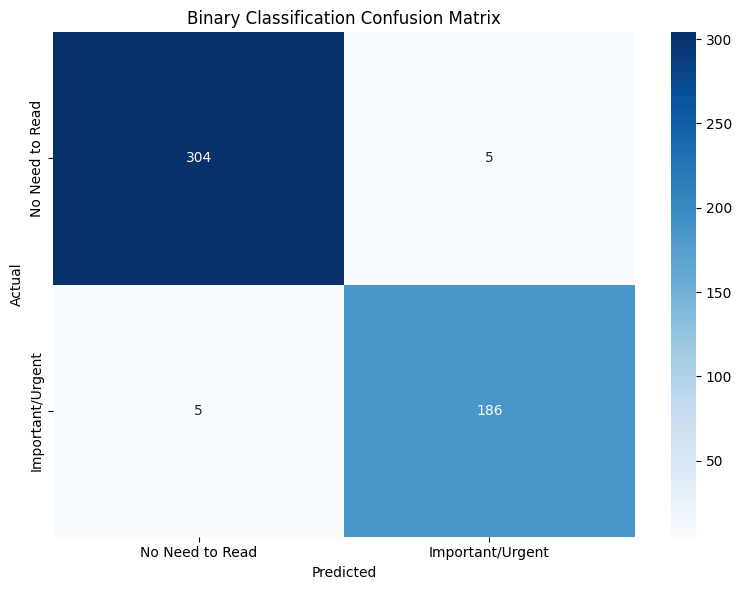

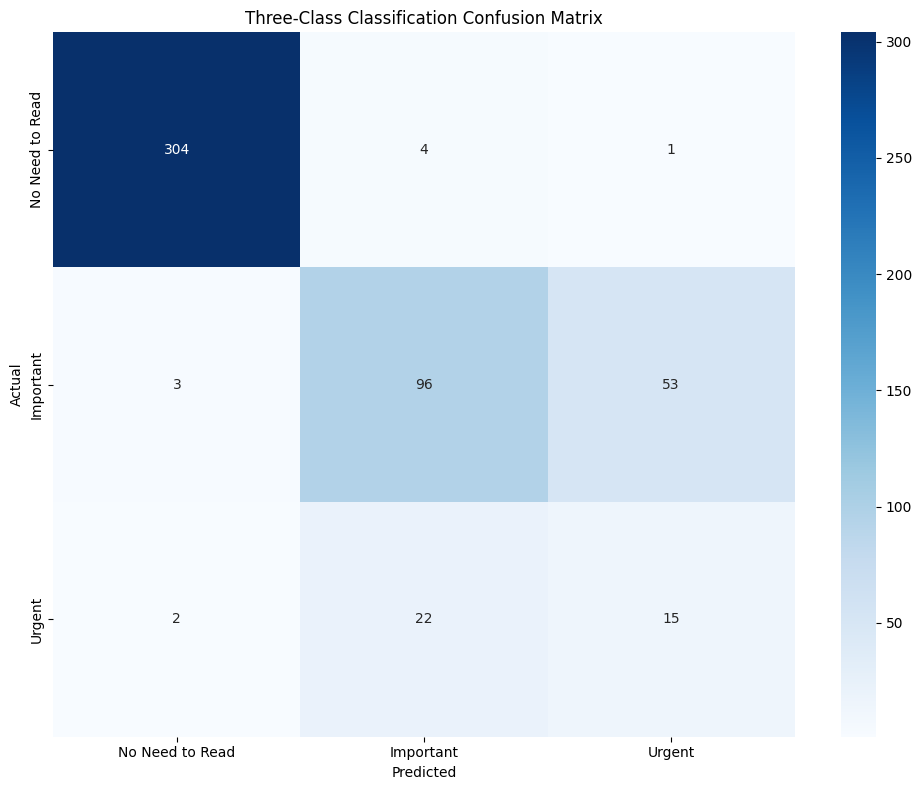

In [22]:
import pandas as pd
import numpy as np
import re
import nltk
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Download necessary NLTK resources
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
except:
    print("NLTK resources download failed. Some features might not work properly.")

# Custom transformer to handle different input types
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key."""
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return [item[self.key] for item in data_dict]

# Feature extraction classes
class EmailExtractor(BaseEstimator, TransformerMixin):
    """Extract email domains from sender field and one-hot encode them"""
    def __init__(self):
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.domains_seen = set()

    def fit(self, x, y=None):
        # Extract domains and fit the encoder
        domains = self._extract_domains(x)
        self.domains_seen = set(domains)

        # Reshape domains for OneHotEncoder
        domains_array = np.array(domains).reshape(-1, 1)
        self.encoder.fit(domains_array)
        return self

    def transform(self, data):
        # Extract domains
        domains = self._extract_domains(data)

        # Reshape domains for OneHotEncoder
        domains_array = np.array(domains).reshape(-1, 1)

        # Transform to one-hot encoding
        return self.encoder.transform(domains_array)

    def _extract_domains(self, data):
        # Extract email and domain
        email_pattern = r'[a-zA-Z0-9._%+-]+@([a-zA-Z0-9.-]+\.[a-zA-Z]{2,})'
        domains = []

        for text in data:
            match = re.search(email_pattern, str(text))
            domain = match.group(1) if match else "unknown"
            domains.append(domain)

        return domains

class DateExtractor(BaseEstimator, TransformerMixin):
    """Extract date features from emails"""
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        date_features = []

        for text in data:
            text = str(text)  # Ensure text is string, not numpy array
            # Look for common date patterns
            date_patterns = [
                r'\b\d{1,2}/\d{1,2}/\d{2,4}\b',  # MM/DD/YYYY or DD/MM/YYYY
                r'\b\d{1,2}-\d{1,2}-\d{2,4}\b',  # MM-DD-YYYY or DD-MM-YYYY
                r'\b\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{2,4}\b',  # DD Mon YYYY
                r'\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{1,2},?\s+\d{2,4}\b',  # Mon DD, YYYY
                r'\b(?:Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)[a-z]*,?\s+\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{2,4}\b',  # Weekday, DD Mon YYYY
            ]

            # Default values
            has_date = 0
            is_weekend = 0
            hour_of_day = -1

            # Check for each date pattern
            for pattern in date_patterns:
                match = re.search(pattern, text, re.IGNORECASE)
                if match:
                    has_date = 1
                    # More sophisticated date parsing could be done here
                    break

            # Look for time expressions
            time_pattern = r'\b(?:1[0-2]|0?[1-9]):[0-5][0-9]\s*(?:am|pm|AM|PM)?\b|\b(?:2[0-3]|[01]?[0-9]):[0-5][0-9]\b'
            time_match = re.search(time_pattern, text)
            if time_match:
                # Could extract hour information here
                has_time = 1
            else:
                has_time = 0

            # Check for "urgent" time expressions
            urgent_time_patterns = [
                r'\btoday\b', r'\basap\b', r'\bas soon as possible\b',
                r'\bimmediately\b', r'\burgent\b', r'\bdeadline\b',
                r'\bcod\b', r'\bclose of day\b', r'\beod\b', r'\bend of day\b'
            ]

            has_urgent_time = 0
            for pattern in urgent_time_patterns:
                if re.search(pattern, text, re.IGNORECASE):
                    has_urgent_time = 1
                    break

            date_features.append([
                has_date,
                has_time,
                has_urgent_time
            ])

        return np.array(date_features)  # Return numpy array

class UrgencyKeywordExtractor(BaseEstimator, TransformerMixin):
    """Extract urgency keywords from text"""
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        # Keywords for different urgency levels
        urgent_keywords = [
            'urgent', 'immediate', 'asap', 'emergency', 'critical', 'crucial',
            'important', 'priority', 'deadline', 'attention', 'respond', 'now',
            'today', 'quickly', 'action', 'required', 'needed', 'necessary',
            'vital', 'essential', 'alert', 'warning', 'immediately', 'expedite'
        ]

        important_keywords = [
            'important', 'review', 'update', 'please', 'request', 'information',
            'follow-up', 'followup', 'consider', 'attention', 'fyi', 'notification',
            'reminder', 'weekly', 'monthly', 'report'
        ]

        ignore_keywords = [
            'newsletter', 'subscription', 'unsubscribe', 'discount', 'offer',
            'promotion', 'sale', 'digest', 'automated', 'do not reply'
        ]

        features = []
        for text in data:
            text = str(text).lower()  # Ensure text is string, not numpy array

            # Count occurrences of each type of keyword
            urgent_count = sum(1 for keyword in urgent_keywords if keyword in text)
            important_count = sum(1 for keyword in important_keywords if keyword in text)
            ignore_count = sum(1 for keyword in ignore_keywords if keyword in text)

            # Calculate ratios
            total_words = len(text.split())
            urgent_ratio = urgent_count / max(1, total_words)
            important_ratio = important_count / max(1, total_words)
            ignore_ratio = ignore_count / max(1, total_words)

            features.append([
                urgent_count,
                important_count,
                ignore_count,
                urgent_ratio,
                important_ratio,
                ignore_ratio
            ])

        return np.array(features)  # Return numpy array directly

class SubjectFeatureExtractor(BaseEstimator, TransformerMixin):
    """Extract specific features from subject lines"""
    def fit(self, x, y=None):
        return self

    def transform(self, subjects):
        features = []

        for subject in subjects:
            subject = str(subject)  # Ensure subject is string, not numpy array

            # Extract features from subject
            has_exclamation = int('!' in subject)
            has_question = int('?' in subject)
            all_caps = int(subject.isupper() and len(subject) > 3)
            length = len(subject)
            word_count = len(subject.split())

            # Check for prefixes like RE:, FWD:
            is_reply = int(bool(re.match(r'^\s*re:', subject, re.IGNORECASE)))
            is_forward = int(bool(re.match(r'^\s*(?:fw|fwd):', subject, re.IGNORECASE)))

            # Capitalization patterns
            first_word_caps = 0
            if word_count > 0:
                first_word = subject.split()[0]
                if len(first_word) > 1 and first_word[0].isupper():
                    first_word_caps = 1

            features.append([
                has_exclamation,
                has_question,
                all_caps,
                length,
                word_count,
                is_reply,
                is_forward,
                first_word_caps
            ])

        return np.array(features)  # Return numpy array directly

class TextLengthExtractor(BaseEstimator, TransformerMixin):
    """Extract length-based features from text"""
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        features = []

        for text in data:
            text = str(text)  # Ensure text is string, not numpy array

            # Basic length metrics
            char_count = len(text)
            word_count = len(text.split())
            sentence_count = max(1, len(re.split(r'[.!?]+', text)) - 1)  # Avoid division by zero

            # Calculate averages
            avg_word_length = char_count / max(1, word_count)
            avg_sentence_length = word_count / max(1, sentence_count)

            features.append([
                char_count,
                word_count,
                sentence_count,
                avg_word_length,
                avg_sentence_length
            ])

        return np.array(features)  # Return numpy array directly

def detect_urgency(subject, body):
    """Detect if an email classified as Important is actually Urgent based on time indicators"""

    # Combine subject and body for analysis
    text = (subject + " " + body).lower()

    # Check for urgent time expressions
    urgent_time_patterns = [
        r'\btoday\b', r'\basap\b', r'\bas soon as possible\b',
        r'\bimmediately\b', r'\burgent\b', r'\bdeadline\b',
        r'\bcod\b', r'\bclose of day\b', r'\beod\b', r'\bend of day\b',
        r'\bdue\s+today\b', r'\boverdue\b', r'\bemergency\b', r'\bcritical\b',
        r'\bimminent\b', r'\bpressing\b', r'\btop\s+priority\b',
        r'\bexpedite\b', r'\bsoonest\b', r'\bprompt\s+attention\b'
    ]

    # Check for date expressions like "tomorrow" or dates within 2 days
    date_urgency_patterns = [
        r'\btomorrow\b', r'\btonight\b', r'\bthis\s+evening\b',
        r'\bin\s+\d+\s+hour', r'\bin\s+the\s+next\s+\d+\s+hour',
        r'\bby\s+end\s+of\s+day\b', r'\bby\s+eod\b', r'\bby\s+cod\b',
        r'\bby\s+noon\b', r'\bby\s+morning\b', r'\bby\s+the\s+end\s+of\b'
    ]

    # Look for time stamps and check if they're within 48 hours
    date_pattern = r'\b\d{1,2}[/\-]\d{1,2}[/\-]\d{2,4}\b'
    date_matches = re.findall(date_pattern, text)

    # Check for multiple exclamation marks or urgent formatting
    formatting_patterns = [
        r'!!+',  # Multiple exclamation marks
        r'\*urgent\*', r'\*important\*', r'\*priority\*',  # Asterisk emphasis
        r'URGENT', r'ASAP', r'IMMEDIATE',  # All caps urgency
    ]

    # Check for any urgency pattern matches
    for pattern in urgent_time_patterns + date_urgency_patterns + formatting_patterns:
        if re.search(pattern, text, re.IGNORECASE):
            return True

    # Additional logic for dates could be added here
    # For example, parse dates and compare with current date

    return False

def load_and_preprocess_data(file_path):
    """Load email data and preprocess it for advanced feature extraction"""
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded with {len(df)} emails")

        # Print column names
        print(f"Available columns: {df.columns.tolist()}")

        # Get column names from user
        sender_col = 'sender'
        subject_col = 'subject'
        body_col = 'body'
        label_col = 'label'

        # Validate columns exist
        for col, name in [(sender_col, "sender"), (subject_col, "subject"),
                         (body_col, "body"), (label_col, "label")]:
            if col not in df.columns:
                print(f"Warning: {name} column '{col}' not found. Using empty strings.")
                df[col] = ""

        # Ensure correct data types
        df[sender_col] = df[sender_col].astype(str)
        df[subject_col] = df[subject_col].astype(str)
        df[body_col] = df[body_col].astype(str)

        # Convert labels to integers if needed
        if df[label_col].dtype != 'int64':
            try:
                df[label_col] = df[label_col].astype(int)
                print("Converted labels to integers")
            except:
                print("Error: Could not convert labels to integers.")
                return None

        # Convert to binary classification if 3-class data is detected
        if df[label_col].max() == 2:  # If you have 3-class data (0,1,2)
            print("Converting to binary classification (0=Don't Read, 1=Important/Urgent)")
            # Convert labels 1 and 2 to just 1 (combine Important and Urgent)
            df[label_col] = (df[label_col] > 0).astype(int)

        # Check label distribution
        print(f"\nLabel distribution:")
        label_counts = df[label_col].value_counts().sort_index()
        for label, count in label_counts.items():
            label_name = "Don't Read" if label == 0 else "Important"
            print(f"  {label_name}: {count} ({count/len(df)*100:.1f}%)")

        # Create named columns for easier reference
        result_df = df.rename(columns={
            sender_col: 'sender',
            subject_col: 'subject',
            body_col: 'body',
            label_col: 'label'
        })

        return result_df

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

def build_advanced_model():
    """Build a binary email classification model with rich feature extraction"""

    # Create the full pipeline - simplified structure to fix nested pipeline warnings
    pipeline = Pipeline([
        ('features', FeatureUnion([
            # Sender features
            ('sender_email', Pipeline([
                ('selector', ItemSelector('sender')),
                ('email_extractor', EmailExtractor())
            ])),

            # Subject features - split into separate pipelines to avoid nesting issues
            ('subject_urgency', Pipeline([
                ('selector', ItemSelector('subject')),
                ('urgency', UrgencyKeywordExtractor())
            ])),
            ('subject_features', Pipeline([
                ('selector', ItemSelector('subject')),
                ('extractor', SubjectFeatureExtractor())
            ])),
            ('subject_date', Pipeline([
                ('selector', ItemSelector('subject')),
                ('date', DateExtractor())
            ])),
            ('subject_tfidf', Pipeline([
                ('selector', ItemSelector('subject')),
                ('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 2)))
            ])),

            # Body features - split into separate pipelines
            ('body_urgency', Pipeline([
                ('selector', ItemSelector('body')),
                ('urgency', UrgencyKeywordExtractor())
            ])),
            ('body_length', Pipeline([
                ('selector', ItemSelector('body')),
                ('length', TextLengthExtractor())
            ])),
            ('body_date', Pipeline([
                ('selector', ItemSelector('body')),
                ('date', DateExtractor())
            ])),
            ('body_tfidf', Pipeline([
                ('selector', ItemSelector('body')),
                ('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2)))
            ]))
        ])),
        # Using a binary classifier with balanced class weights
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
    ])

    return pipeline

def evaluate_model(model, X_test, y_test, X_test_sender=None, X_test_subject=None, X_test_body=None):
    """Evaluate the model and show detailed performance metrics"""

    # Make predictions
    y_pred = model.predict(X_test)

    # Generate classification report
    print("\nBinary Classification Report:")
    class_names = ['No Need to Read', 'Important']
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Binary Classification Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix_binary.png')
    print("Confusion matrix saved as 'confusion_matrix_binary.png'")

    # Now also evaluate the urgency detection on the "Important" emails
    if 1 in y_pred:
        # Get indices of emails classified as Important
        important_indices = [i for i, p in enumerate(y_pred) if p == 1]

        # For each Important email, check if it's urgent
        urgency_results = []
        for idx in important_indices:
            if isinstance(X_test, list):
                subject = X_test[idx]['subject']
                body = X_test[idx]['body']
            else:
                subject = X_test_subject.iloc[idx]
                body = X_test_body.iloc[idx]

            is_urgent = detect_urgency(subject, body)
            urgency_results.append(is_urgent)

        # Print urgency detection results
        urgent_count = sum(urgency_results)
        print(f"\nUrgency Detection Results:")
        print(f"  Out of {len(urgency_results)} emails classified as Important:")
        print(f"  - {urgent_count} detected as Urgent ({urgent_count/len(urgency_results)*100:.1f}%)")
        print(f"  - {len(urgency_results)-urgent_count} detected as Standard Important ({(len(urgency_results)-urgent_count)/len(urgency_results)*100:.1f}%)")

    return y_pred

def save_model(model, filename='binary_email_classifier.pkl'):
    """Save the trained model"""
    joblib.dump(model, filename)
    print(f"Model saved as '{filename}'")

def load_model(filename='binary_email_classifier.pkl'):
    """Load a saved model"""
    try:
        model = joblib.load(filename)
        print(f"Model loaded from '{filename}'")
        return model
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None

def classify_new_email(model, sender, subject, body):
    """Classify a new email using the two-stage approach:
    1. Binary classification (No Need to Read vs Important)
    2. For Important emails, determine if they're urgent
    """
    # Create combined input format
    email_input = [{
        'sender': sender,
        'subject': subject,
        'body': body
    }]

    # First level classification - Important or Not
    prediction = model.predict(email_input)[0]

    # For emails classified as Important (1), check if they're Urgent
    if prediction == 1 and detect_urgency(subject, body):
        return 'Urgent'

    # Map numerical prediction to text
    label_map = {0: 'No Need to Read', 1: 'Important'}
    return label_map[prediction]

def prepare_data_format(df_sender, df_subject, df_body):
    """Prepare data in the required dictionary format"""
    data = []
    for i in range(len(df_sender)):
        data.append({
            'sender': df_sender.iloc[i],
            'subject': df_subject.iloc[i],
            'body': df_body.iloc[i]
        })
    return data

def main():
    print("=== Enhanced Email Classification System with Two-Stage Approach ===")
    print("This system uses binary classification + urgency detection for better email prioritization")

    option = input("Choose an option:\n1. Train new model\n2. Load existing model and classify emails\nChoice: ")

    if option == '1':
        # Train new binary model
        file_path = input("Enter path to your CSV file: ")
        df = load_and_preprocess_data(file_path)

        if df is None:
            print("Error processing data. Exiting.")
            return

        # Split data for training
        X_sender = df['sender']
        X_subject = df['subject']
        X_body = df['body']
        y = df['label']  # Now binary (0 = Don't Read, 1 = Important)

        X_train_sender, X_test_sender, y_train, y_test = train_test_split(
            X_sender, y, test_size=0.2, random_state=42, stratify=y
        )

        # Get the same indices for subject and body
        train_indices = X_train_sender.index
        test_indices = X_test_sender.index

        X_train_subject = X_subject.loc[train_indices]
        X_test_subject = X_subject.loc[test_indices]

        X_train_body = X_body.loc[train_indices]
        X_test_body = X_body.loc[test_indices]

        # Prepare data in dictionary format
        X_train = prepare_data_format(X_train_sender, X_train_subject, X_train_body)
        X_test = prepare_data_format(X_test_sender, X_test_subject, X_test_body)

        print("\nTraining binary classification model...")
        pipeline = build_advanced_model()

        # Fit the model
        pipeline.fit(X_train, y_train)

        print("Evaluating model...")
        evaluate_model(pipeline, X_test, y_test, X_test_sender, X_test_subject, X_test_body)

        # Save model
        save_model(pipeline)

        # Show examples of classification with two-stage approach
        print("\nExample Classifications (Two-Stage Approach):")
        for i in range(min(5, len(X_test))):
            # Get binary prediction
            email_input = [{
                'sender': X_test_sender.iloc[i],
                'subject': X_test_subject.iloc[i],
                'body': X_test_body.iloc[i]
            }]
            binary_pred = pipeline.predict(email_input)[0]

            # Apply urgency detection
            final_prediction = classify_new_email(
                pipeline,
                X_test_sender.iloc[i],
                X_test_subject.iloc[i],
                X_test_body.iloc[i]
            )

            actual_binary = {0: 'No Need to Read', 1: 'Important'}[y_test.iloc[i]]

            print(f"\nEmail {i+1}:")
            print(f"Sender: {X_test_sender.iloc[i]}")
            print(f"Subject: {X_test_subject.iloc[i]}")
            print(f"Body: {X_test_body.iloc[i][:100]}...")
            print(f"Binary Prediction: {binary_pred} ({actual_binary})")
            print(f"Final Classification: {final_prediction}")

            if binary_pred == 1:
                # Show urgency markers if found
                is_urgent = detect_urgency(X_test_subject.iloc[i], X_test_body.iloc[i])
                if is_urgent:
                    print("Urgency markers detected!")

    elif option == '2':
        # Load existing model
        model_path = input("Enter path to saved model (default: binary_email_classifier.pkl): ").strip() or "binary_email_classifier.pkl"
        model = load_model(model_path)

        if model is None:
            print("Error loading model. Exiting.")
            return

        # Choose classification method
        classify_option = input("\nChoose classification method:\n1. Single email\n2. Batch from CSV\nChoice: ")

        if classify_option == '1':
            # Classify single email
            sender = input("Enter sender email: ")
            subject = input("Enter email subject: ")
            body = input("Enter email body: ")

            # Get binary prediction
            email_input = [{
                'sender': sender,
                'subject': subject,
                'body': body
            }]
            binary_pred = model.predict(email_input)[0]
            binary_label = 'No Need to Read' if binary_pred == 0 else 'Important'

            # Check for urgency if important
            result = classify_new_email(model, sender, subject, body)

            print(f"\nBinary Classification: {binary_label}")
            print(f"Final Classification: {result}")

            if binary_pred == 1:
                # Show urgency markers if found
                is_urgent = detect_urgency(subject, body)
                if is_urgent:
                    print("Urgency markers detected!")

        elif classify_option == '2':
            # Batch classification
            csv_path = input("Enter path to CSV with emails to classify: ")
            df = load_and_preprocess_data(csv_path)

            if df is None:
                print("Error processing data. Exiting.")
                return

            # Classify all emails
            print("Classifying emails using two-stage approach...")
            binary_predictions = []
            final_predictions = []

            for i, row in df.iterrows():
                # Get binary prediction first
                email_input = [{
                    'sender': row['sender'],
                    'subject': row['subject'],
                    'body': row['body']
                }]
                binary_pred = model.predict(email_input)[0]
                binary_label = 'No Need to Read' if binary_pred == 0 else 'Important'
                binary_predictions.append(binary_label)

                # Check for urgency for important emails
                if binary_pred == 1 and detect_urgency(row['subject'], row['body']):
                    final_predictions.append('Urgent')
                else:
                    final_predictions.append(binary_label)

            # Add predictions to dataframe
            df['binary_prediction'] = binary_predictions
            df['final_prediction'] = final_predictions

            # Save results
            output_path = input("Enter path to save classification results: ")
            df.to_csv(output_path, index=False)
            print(f"Classification results saved to {output_path}")

            # Show summary
            print("\nBinary Classification Summary:")
            binary_summary = pd.Series(binary_predictions).value_counts()
            for label, count in binary_summary.items():
                print(f"{label}: {count} ({count/len(df)*100:.1f}%)")

            print("\nFinal Classification Summary (with Urgency Detection):")
            final_summary = pd.Series(final_predictions).value_counts()
            for label, count in final_summary.items():
                print(f"{label}: {count} ({count/len(df)*100:.1f}%)")
    elif option == '3':
        # Evaluate model on a labeled dataset
        model_path = input("Enter path to saved model (default: binary_email_classifier.pkl): ").strip() or "binary_email_classifier.pkl"
        model = load_model(model_path)

        if model is None:
            print("Error loading model. Exiting.")
            return

        labeled_data_path = input("Enter path to labeled dataset CSV: ")
        evaluation_results = evaluate_with_labeled_dataset(model, labeled_data_path)

        if evaluation_results:
            # Additional analysis could be done here with the returned results
            print("\nEvaluation complete!")

    else:
        print("Invalid option selected.")

# Create EmailClassifierService class for integration with other systems
class EmailClassifierService:
    def __init__(self, model_path='binary_email_classifier.pkl'):
        """Initialize the email classifier service"""
        self.model = joblib.load(model_path)
        print(f"Model loaded from '{model_path}'")

    def detect_urgency(self, subject, body):
        """Detect if an email is urgent based on time indicators"""
        return detect_urgency(subject, body)

    def classify_email(self, sender, subject, body):
        """Classify an email using the two-stage approach"""
        # Create input format
        email_input = [{
            'sender': sender,
            'subject': subject,
            'body': body
        }]

        # First-stage classification (binary)
        binary_pred = self.model.predict(email_input)[0]

        # For Important emails, check if urgent
        if binary_pred == 1 and self.detect_urgency(subject, body):
            return 'Urgent'

        # Map binary prediction to label
        return 'No Need to Read' if binary_pred == 0 else 'Important'

    def batch_classify(self, emails_df):
        """Classify multiple emails in batch"""
        results = []
        for i, row in emails_df.iterrows():
            result = self.classify_email(row['sender'], row['subject'], row['body'])
            results.append(result)

        return results

if __name__ == "__main__":
    main()

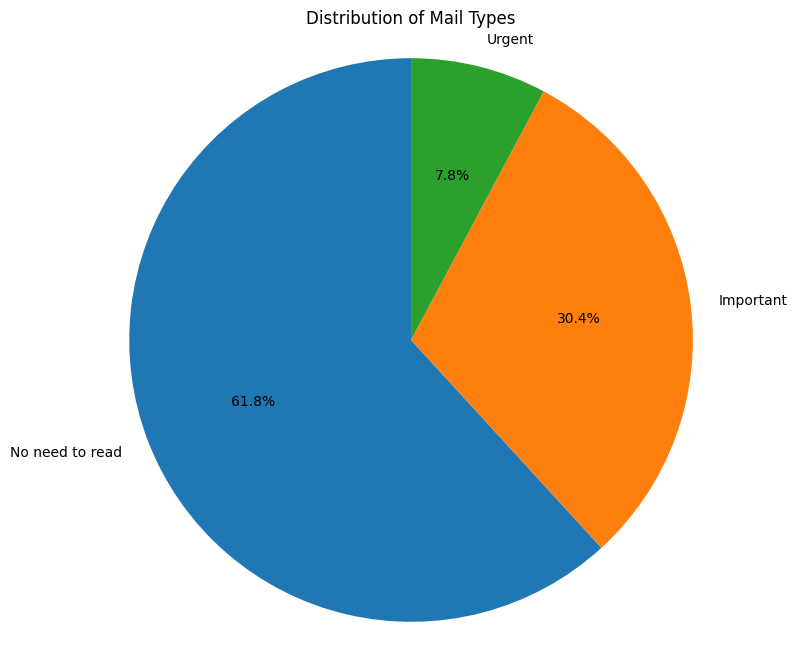

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your DataFrame is named 'df' and has a column named 'label'
df = pd.read_csv('emails-500.csv')
mail_counts = df['label'].value_counts()

# Dictionary for label mapping
d = {0: "No need to read", 1: "Important", 2: "Urgent"}

# Map the index values to their corresponding labels
labels = [d[i] for i in mail_counts.index]

plt.figure(figsize=(8, 8))
plt.pie(mail_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Mail Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [21]:
def evaluate_with_labeled_dataset(model, labeled_data_path):
    """
    Evaluate the email classification model using a labeled dataset with three classes:
    0 = No Need to Read, 1 = Important, 2 = Urgent

    Parameters:
    -----------
    model : sklearn.pipeline.Pipeline
        The trained email classification model
    labeled_data_path : str
        Path to the CSV file containing labeled data

    Returns:
    --------
    dict
        Dictionary with evaluation metrics and confusion matrices
    """
    print(f"=== Evaluating Model with Labeled Dataset ===")
    print(f"Loading data from {labeled_data_path}")

    # Load the labeled dataset
    df = pd.read_csv(labeled_data_path)
    print(f"Dataset loaded with {len(df)} emails")

    # Determine column names
    required_cols = ['sender', 'subject', 'body', 'label']
    for col in required_cols:
        if col not in df.columns:
            print(f"Error: Required column '{col}' not found in dataset")
            return None

    # Prepare inputs and labels
    X_sender = df['sender']
    X_subject = df['subject']
    X_body = df['body']
    y_true = df['label']  # Original 3-class labels

    # Prepare data in dictionary format for model input
    X_test = []
    for i in range(len(df)):
        X_test.append({
            'sender': X_sender.iloc[i],
            'subject': X_subject.iloc[i],
            'body': X_body.iloc[i]
        })

    # Get binary predictions from the model (0 = Don't Read, 1 = Important)
    print("Making binary predictions...")
    y_pred_binary = model.predict(X_test)

    # Apply urgency detection to create 3-class predictions
    print("Applying urgency detection...")
    y_pred_three_class = []
    for i, pred in enumerate(y_pred_binary):
        if pred == 0:
            # No need to read
            y_pred_three_class.append(0)
        else:
            # Check if important (1) or urgent (2)
            is_urgent = detect_urgency(X_subject.iloc[i], X_body.iloc[i])
            y_pred_three_class.append(2 if is_urgent else 1)

    # Create binary version of the true labels (0 = Don't Read, 1 = Important/Urgent)
    y_true_binary = (y_true > 0).astype(int)

    # === Evaluation for binary classification ===
    binary_class_names = ['No Need to Read', 'Important/Urgent']
    print("\n=== Binary Classification Evaluation ===")
    print("Classification Report:")
    binary_report = classification_report(y_true_binary, y_pred_binary,
                                         target_names=binary_class_names, output_dict=True)
    print(classification_report(y_true_binary, y_pred_binary, target_names=binary_class_names))

    # Create confusion matrix for binary classification
    binary_cm = confusion_matrix(y_true_binary, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(binary_cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=binary_class_names,
               yticklabels=binary_class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Binary Classification Confusion Matrix')
    plt.tight_layout()
    binary_cm_filename = 'binary_confusion_matrix.png'
    plt.savefig(binary_cm_filename)
    print(f"Binary confusion matrix saved as '{binary_cm_filename}'")

    # === Evaluation for three-class classification ===
    three_class_names = ['No Need to Read', 'Important', 'Urgent']
    print("\n=== Three-Class Classification Evaluation ===")
    print("Classification Report:")
    three_class_report = classification_report(y_true, y_pred_three_class,
                                              target_names=three_class_names, output_dict=True)
    print(classification_report(y_true, y_pred_three_class, target_names=three_class_names))

    # Create confusion matrix for three-class classification
    three_class_cm = confusion_matrix(y_true, y_pred_three_class)
    plt.figure(figsize=(10, 8))
    sns.heatmap(three_class_cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=three_class_names,
               yticklabels=three_class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Three-Class Classification Confusion Matrix')
    plt.tight_layout()
    three_class_cm_filename = 'three_class_confusion_matrix.png'
    plt.savefig(three_class_cm_filename)
    print(f"Three-class confusion matrix saved as '{three_class_cm_filename}'")

    # Analyze errors
    print("\n=== Error Analysis ===")

    # Identify misclassified emails
    misclassified_indices = [i for i in range(len(y_true)) if y_true.iloc[i] != y_pred_three_class[i]]
    print(f"Total misclassified emails: {len(misclassified_indices)} out of {len(y_true)} ({len(misclassified_indices)/len(y_true)*100:.1f}%)")

    # Calculate error types
    error_types = {}
    for i in misclassified_indices:
        true_label = y_true.iloc[i]
        pred_label = y_pred_three_class[i]
        error_key = f"{three_class_names[true_label]} → {three_class_names[pred_label]}"

        if error_key not in error_types:
            error_types[error_key] = 0
        error_types[error_key] += 1

    # Print error types
    print("Error types:")
    for error_type, count in sorted(error_types.items(), key=lambda x: x[1], reverse=True):
        print(f"  {error_type}: {count} ({count/len(misclassified_indices)*100:.1f}% of errors)")

    # Evaluate urgency detection specifically
    print("\n=== Urgency Detection Evaluation ===")
    # Filter for emails that are either Important or Urgent
    important_indices = [i for i in range(len(y_true)) if y_true.iloc[i] > 0]

    if important_indices:
        # Extract actual and predicted labels for these important/urgent emails
        important_true = [y_true.iloc[i] for i in important_indices]
        important_pred = [y_pred_three_class[i] for i in important_indices]

        # Count correct and incorrect urgency classifications
        correct_urgent = sum(1 for i, idx in enumerate(important_indices)
                             if important_true[i] == 2 and important_pred[i] == 2)
        missed_urgent = sum(1 for i, idx in enumerate(important_indices)
                           if important_true[i] == 2 and important_pred[i] == 1)
        false_urgent = sum(1 for i, idx in enumerate(important_indices)
                          if important_true[i] == 1 and important_pred[i] == 2)

        total_actual_urgent = sum(1 for label in important_true if label == 2)

        print(f"Total important/urgent emails: {len(important_indices)}")
        print(f"Actual urgent emails: {total_actual_urgent}")
        print(f"Correctly identified urgent emails: {correct_urgent} ({correct_urgent/max(1, total_actual_urgent)*100:.1f}%)")
        print(f"Missed urgent emails: {missed_urgent} ({missed_urgent/max(1, total_actual_urgent)*100:.1f}%)")
        print(f"False urgent classifications: {false_urgent}")

        # Calculate urgency detection metrics
        urgency_precision = correct_urgent / max(1, correct_urgent + false_urgent)
        urgency_recall = correct_urgent / max(1, total_actual_urgent)
        urgency_f1 = 2 * (urgency_precision * urgency_recall) / max(1, urgency_precision + urgency_recall)

        print(f"Urgency Detection Precision: {urgency_precision:.3f}")
        print(f"Urgency Detection Recall: {urgency_recall:.3f}")
        print(f"Urgency Detection F1-Score: {urgency_f1:.3f}")

    # Return evaluation results as a dictionary
    return {
        'binary_report': binary_report,
        'binary_confusion_matrix': binary_cm,
        'three_class_report': three_class_report,
        'three_class_confusion_matrix': three_class_cm,
        'error_types': error_types
    }

In [14]:
evaluate_with_labeled_dataset('binary_email_classifier.pkl','emailt.csv')

=== Evaluating Model with Labeled Dataset ===
Loading data from emailt.csv
Dataset loaded with 500 emails
Making binary predictions...


AttributeError: 'str' object has no attribute 'predict'